In [1]:
import pandas as pd
import joblib  # To save the model

# Load the dataset (if not already in memory)
file_path = "data/featured_clinvar_result.csv"
df = pd.read_csv(file_path)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select features and target
X = df.drop(columns=["position", "label"])
y = df["label"]


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = X_train.astype("int32")
X_test = X_test.astype("int32")


# Reshape for RNN (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train.values, axis=1)  # (samples, 1, features)
X_test_reshaped = np.expand_dims(X_test.values, axis=1)    # (samples, 1, features)

# Check the new shape
X_train_reshaped.shape, X_test_reshaped.shape


((972, 1, 21), (243, 1, 21))

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = np.expand_dims(X_train_scaled.astype(np.float32), axis=1)
X_test_reshaped = np.expand_dims(X_test_scaled.astype(np.float32), axis=1)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the RNN model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, X_train_reshaped.shape[2])),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()


c:\Users\sravy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,129 (94.25 KB)

 Trainable params: 24,129 (94.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:


# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# Convert non-numeric columns to numeric (if needed)
X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(pd.to_numeric, errors='coerce')
X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(pd.to_numeric, errors='coerce')

# Re-check data types
print(X_train.dtypes)


Non-numeric columns: Index([], dtype='object')
Unnamed: 0                    int32
alignment_score               int32
mc_synonymous_variant         int32
mc_3_prime_UTR_variant        int32
mc_5_prime_UTR_variant        int32
mc_splice_donor_variant       int32
mc_splice_acceptor_variant    int32
mc_nonsense                   int32
mc_intron_variant             int32
mc_missense_variant           int32
mc_stop_lost                  int32
splice_distance               int32
type                          int32
prev_A                        int32
prev_C                        int32
prev_G                        int32
prev_T                        int32
next_A                        int32
next_C                        int32
next_G                        int32
next_T                        int32
dtype: object


In [6]:
import numpy as np

# Convert to numpy before reshaping
X_train_reshaped = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    LSTM(64, input_shape=(1, X_train.shape[1])),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test)
)

c:\Users\sravy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5367 - loss: 0.6904 - val_accuracy: 0.6255 - val_loss: 0.6476
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5790 - loss: 0.6555 - val_accuracy: 0.6255 - val_loss: 0.6395
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5690 - loss: 0.6563 - val_accuracy: 0.6379 - val_loss: 0.6368
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6263 - loss: 0.6299 - val_accuracy: 0.6008 - val_loss: 0.6387
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5861 - loss: 0.6470 - val_accuracy: 0.6049 - val_loss: 0.6395
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5998 - loss: 0.6413 - val_accuracy: 0.6214 - val_loss: 0.6325
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6179 - loss: 0.6361 - val_accuracy: 0.6379 - val_loss: 0.6264
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6328 - loss: 0.6191 - val_accuracy: 0.6461 - 

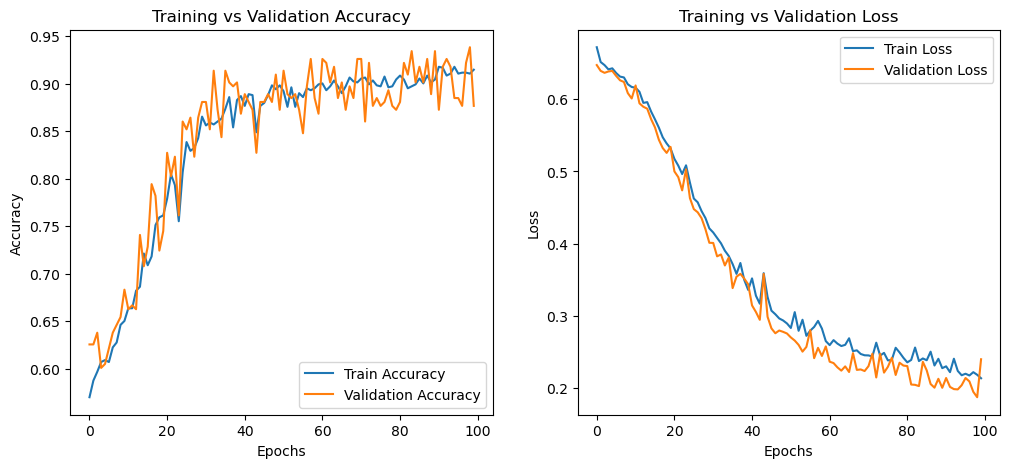

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


In [9]:
# Make predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Print some sample predictions
print("Predicted labels:", y_pred[:10].flatten())
print("Actual labels:   ", y_test[:10].values)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted labels: [0 0 0 1 0 1 1 1 0 0]
Actual labels:    [0 0 0 1 0 1 0 1 0 0]


In [10]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.82      0.97      0.89       126
           1       0.96      0.78      0.86       117

    accuracy                           0.88       243
   macro avg       0.89      0.87      0.87       243
weighted avg       0.89      0.88      0.88       243

[[122   4]
 [ 26  91]]


In [11]:
model_path = "models/rnn_model.pkl"
joblib.dump(y_pred_probs, model_path)

print(f"✅ Model Saved at: {model_path}")

✅ Model Saved at: models/rnn_model.pkl
